# Align and remove under/overexposed images

This notebook removes any under/overexposed frames from timelapse experiments and aligns the images. 

### The aligned images will be used later in the object localisation and tracking steps. 

The structure of this notebook is:

1. Load images using the octopuslite dask loader.
2. Find over/underexposed images by measuring each channel and frame for average pixel intensity.
3. Select a reference channel to center the alignment on
4. Register alignment and save out transformation tensor
5. (Optional) Apply transformation matrix to all channels and save out images
6. Check images using Napari
7. Function to iterate over many experiments, many positions

In [7]:
import os
import glob
import enum
import numpy as np
from pystackreg import StackReg
from skimage.io import imsave
from tqdm.auto import tqdm
from octopuslite import DaskOctopusLiteLoader
from skimage import transform as tf
from tqdm.auto import tqdm
from skimage.io import imread

In [2]:
def image_generator(files, crop = None):
    """
    Generator function for iterative procesessing of image files
    """
    
    if crop is None:
        for filename in files:
            img = imread(filename)
            yield img
    else:
        for filename in files:
            img = imread(filename)
            img = crop_image(img, crop)
            yield img

## 1. Find images, organise and load using octopuslite

Define root directory and specific experiment and location to align

In [3]:
root_dir = '/home/nathan/data/kraken/ras'
expt = 'ND0013'
pos = 'Pos13'

Create new subdir for image files and move them all there. This is so that the miscelleanous non-image files (such as transformation matrices and tracking files) are easy to access later on and not lost amongst many single frame timelapse images.

In [9]:
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
if not os.path.exists(image_path):
    os.mkdir(image_path)
    files = sorted(glob.glob(f'{root_dir}/{expt}/{pos}/*.tif'))
    for file in files:
        os.rename(file, file.replace(f'{pos}', f'{pos}/{pos}_images'))

Lazily load image array and associated information using dask octopuslite-loader and display channels found. Note the optional background removal is not invoked at this stage.

In [24]:
images = DaskOctopusLiteLoader(image_path, remove_background = False)
print([channel.name for channel in images.channels])

['BRIGHTFIELD', 'GFP', 'RFP', 'IRFP', 'MASK']


## 2. Identify under/overexposed images and display average channel brightness

In [25]:
images['brightfield']

dask.array<stack, shape=(2813, 1352, 1688), dtype=uint8, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

In [26]:
%%time
# pixel range criteria
max_pixel, min_pixel = 200, 2
# set empty dict arrays for mean values 
mean_arrays = {}
# set for dodgy frames (only unique entries)
dodgy_frame_list = set([])
#iterate over channels
for channel in tqdm(images.channels, desc = f'Finding mean values of image channels'):
    # find mean value of each frame in each channel
    print(channel.name)
    if channel.name == 'MASK':
        continue
    mean_arrays[channel.name] = [np.mean(img) for img in tqdm(image_generator(images.files(channel.name)), position = 0, total =len(images.files(channel.name)))]
    # iterate over frames
    for frame, mean_value in (enumerate(mean_arrays[channel.name])):
        # check to see if mean frame pixel value meets criteria
        if max_pixel < mean_value or mean_value < min_pixel:
            # if so add to delete list
            dodgy_frame_list.add(frame)
# format delete list to only include single values
dodgy_frame_list = list(dodgy_frame_list)
print('Number of under/over-exposed frames:', len(dodgy_frame_list))

Finding mean values of image channels:   0%|          | 0/5 [00:00<?, ?it/s]

BRIGHTFIELD


  0%|          | 0/2813 [00:00<?, ?it/s]

GFP


  0%|          | 0/2813 [00:00<?, ?it/s]

RFP


  0%|          | 0/2813 [00:00<?, ?it/s]

IRFP


  0%|          | 0/2813 [00:00<?, ?it/s]

MASK
Number of under/over-exposed frames: 21
CPU times: user 49.6 s, sys: 21.6 s, total: 1min 11s
Wall time: 8min 31s


### 2a. Filter blanks from main image folder into separate directory

This step is optional as there is a parameter within `DaskOctopusLiteLoader` that filters the images, but employing that every time you load images is time consuming for large data sets

In [20]:
# check if blanks dir exists and make if not
if not os.path.exists(f'{root_dir}/{expt}/{pos}/{pos}_blanks'):
    os.mkdir(f'{root_dir}/{expt}/{pos}/{pos}_blanks')
# move blank images into this directory
for channel in images.channels:
    for f in images.files(channel.name):
        for i in dodgy_frame_list:
            if str(i).zfill(9) in f:
                os.rename(f, f.replace('_images', '_blanks'))
# reload image arrays now that blanks filtered
images = DaskOctopusLiteLoader(image_path, remove_background = False)
images['gfp']

dask.array<stack, shape=(1092, 1352, 1688), dtype=uint8, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

## 3. Select reference image to base alignment around

Display the average intensities of each channel. The automatically-measured brightest channel isn't necessarily the best.

In [21]:
print('Average channel brightness for selection of reference image:')
for channel in images.channels:
    print(f'{channel.value}: {channel.name}:', np.mean(mean_arrays[channel.name]))

Average channel brightness for selection of reference image:
0: BRIGHTFIELD: 33.73191891389588
1: GFP: 44.73332040857405
2: RFP: 10.141309319858602
3: IRFP: 48.061873736351735
99: MASK: 0.017825675435708743


In [22]:
# manually select reference channel by adding index
reference_channel = images.channels[4]
# automatically select reference channel from max average pixel value (ie. brightest channel)
#reference_channel = images.channels[max([(channel.value, np.mean(mean_arrays[channel.name])) for channel in images.channels])[0]]
reference_channel.name

'MASK'

#### 3a. Set cropped area of reference image to base alignment around 
Cropping as alignment struggles on large arrays such as `shape = (1200,1353,1682)`, this step is optional but you will still need to run `.compute()` on the dask array to load the image into memory to perform the alignment.

In [37]:
%%time
# crop central window out of reference image
reference_image = DaskOctopusLiteLoader(image_path, 
                                        crop = (500, 500)
                                       )[reference_channel.name].compute()
reference_image.shape

Using cropping: (500, 500)
CPU times: user 4min 53s, sys: 3min 39s, total: 8min 32s
Wall time: 55.6 s


(1638, 500, 500)

## 4. Register alignment and save out transformation tensor
Transformation tensor is a 3D series of transformation matrices over time

In [42]:
%%time
# create operator using transformation type (translation)
sr = StackReg(StackReg.TRANSLATION) 

# register each frame to the previous as transformation matrices/tensor
transform_tensor = sr.register_stack(reference_image, reference = 'previous')

# save out transform tensor
np.save(f'{root_dir}/{expt}/{pos}/{reference_channel.name.lower()}_transform_tensor.npy', transform_tensor)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 2 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


CPU times: user 3min 19s, sys: 3.78 s, total: 3min 23s
Wall time: 3min 23s


In [47]:
transform_tensor.shape

(1638, 3, 3)

## 5. (Optional) Apply transformation matrix to all channels and save out images in separate directory

Consumes a lot of time and space to replicate images with minor translational shifts, it is advised to just use the transform parameter in the `DaskOctopusLiteLoader`. 

In [14]:
%%time
### iterating over channels
# create aligned image dir if does not exist 
if not os.path.exists(f'{root_dir}/{expt}/{pos}/{pos}_aligned'):
    os.mkdir(f'{root_dir}/{expt}/{pos}/{pos}_aligned')
# iterate over channels
for channel in images.channels:
    #iterate over all images in channel
    for i in tqdm(range(len(transform_tensor)), 
                  desc = f'Aligning {channel.name.lower()} channel {channel.value+1}/{len(images.channels)}'):
        # load specific transform matrix for that frame
        transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],
                                                 rotation = None)
        # transform image
        transformed_image = (tf.warp(images[channel.name][i,...].compute(), 
                                     transform_matrix, preserve_range=True)).astype(np.uint8)
        # set transformed image pathname by editing base dir
        fn = images.files(channel.name)[i].replace('_images', '_aligned')
        # save trans image out
        imsave(fn, transformed_image, check_contrast=False)

Aligning irfp channel 4/4: 100%|██████████| 1067/1067 [03:04<00:00,  5.79it/s]

CPU times: user 5min 24s, sys: 51.4 s, total: 6min 15s
Wall time: 11min 45s


## 6. Check alignment using Napari

In [53]:
import napari

In [56]:
aligned_images = DaskOctopusLiteLoader(image_path, 
                                       #crop = (1200,1600), 
                                       transforms = f'{root_dir}/{expt}/{pos}/gfp_transform_tensor.npy',
                                       remove_background=False)
viewer = napari.Viewer()
for channel in aligned_images.channels:
    viewer.add_image(aligned_images[channel.name], 
                     name = channel.name, 
                     blending = 'additive', 
                     contrast_limits = [0,255])

## Batch execute

Do all of the above but for many experiment IDs and many positions

In [74]:
import re

In [77]:
root_dir = '/home/nathan/data/kraken/ras'
expt_list = sorted([expt for expt in os.listdir(root_dir) 
                    if 'ND' in expt and os.path.isdir(os.path.join(root_dir, expt))], 
                    key = lambda x: [int(y) for y in re.findall(r'\d+', x)])
max_pixel = 200 
min_pixel = 2
alignment_channel = 'mask'
crop_area = 500
save_out_images = False ### this does not save out a copy of the images, only the transformation matrix
overwrite = True ### this checks for any prexisting transformations and does not overwrite
frame_removal = False ### this boolean choice is for blank frame removal

In [76]:
expt_list

['ND0013',
 'ND0014',
 'ND0016',
 'ND0017',
 'ND0018',
 'ND0019',
 'ND0020',
 'ND0021']

In [78]:
### Iterate over all experiments defined in expt_list
for expt in tqdm(expt_list):
    # Find all positions in that experiment
    pos_list = [pos for pos in os.listdir(f'{root_dir}/{expt}') 
                if 'Pos' in pos 
                and os.path.isdir(f'{root_dir}/{expt}/{pos}')]        
    ### Iterate over all positions in that experiment
    for pos in tqdm(pos_list):
        
        ### check if overwrite param is false check if raw directory already created and if type of transform file already exists and decide whether to skip pos
        if not overwrite and os.path.exists (f'{root_dir}/{expt}/{pos}/{pos}_images') and glob.glob(f'{root_dir}/{expt}/{pos}/*transform*.npy'):
            print(glob.glob(f'{root_dir}/{expt}/{pos}/*transform*.npy'), f'file found, skipping {expt}/{pos}')
            continue

        print(f'Starting {expt}/{pos}')
        
        ### create new subdir of for raw files and move them all there
        image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
        if not os.path.exists(image_path):
            os.mkdir(image_path)
            files = sorted(glob.glob(f'{root_dir}/{expt}/{pos}/*.tif'))
            for file in files:
                os.rename(file, file.replace(f'{pos}', f'{pos}/{pos}_images'))
        
        if frame_removal:
            ### pre load files from raw file dir 
            images = DaskOctopusLiteLoader(image_path, remove_background= False)

            ### measure mean pixel value arrays and use to find under/over-exposed frames
            # set empty dict arrays for mean values 
            mean_arrays = {}
            # set for dodgy frames (only unique entries)
            dodgy_frame_list = set([])
            #iterate over channels
            for channel in tqdm(images.channels, desc = f'Finding mean values of image channels'):
                # find mean value of each frame in each channel
                mean_arrays[channel.name] = [np.mean(img) for img in image_generator(images.files(channel.name))]
                # iterate over frames
                for frame, mean_value in enumerate(mean_arrays[channel.name]):
                    # check to see if mean frame pixel value meets criteria
                    if max_pixel < mean_value or mean_value < min_pixel:
                        # if so add to delete list
                        dodgy_frame_list.add(frame)
            # format delete list to only include single values
            dodgy_frame_list = list(dodgy_frame_list)
            print('Number of under/over-exposed frames:', len(dodgy_frame_list))

            # check if blanks dir exists and make if not
            if not os.path.exists(f'{root_dir}/{expt}/{pos}/{pos}_blanks'):
                os.mkdir(f'{root_dir}/{expt}/{pos}/{pos}_blanks')
            # move blank images into this directory
            for channel in images.channels:
                for f in images.files(channel.name):
                    for i in dodgy_frame_list:
                        if str(i).zfill(9) in f:
                            os.rename(f, f.replace('_images', '_blanks'))

        # crop central window out of reference image with blanks removed
        reference_image = DaskOctopusLiteLoader(image_path, 
                                                crop = (crop_area, crop_area)
                                               )[alignment_channel].compute() 
        ### just gfp masks
        #reference_image = (reference_image == 1).astype(np.uint8)
        ### reverse order of image
        reference_image = np.flip(reference_image, axis = 0)
        
        ### Register alignment
        print('Registering alignment for', pos, expt)
        # create operator using transformation type (translation)
        sr = StackReg(StackReg.TRANSLATION) 
        # register each frame to the previous as transformation matrices/tensor
        transform_tensor = sr.register_stack(reference_image, reference = 'previous')
        
        ### switch orientation again back to norm
        transform_tensor = np.flip(transform_tensor, axis = 0)
        
        # save out transform tensor
        np.save(f'{root_dir}/{expt}/{pos}/{alignment_channel}_reversed_clipped_transform_tensor.npy', transform_tensor)

        if save_out_images:
            ### Perform alignment
            # create aligned image dir if does not exist 
            if not os.path.exists(f'{root_dir}/{expt}/{pos}/{pos}_aligned'):
                os.mkdir(f'{root_dir}/{expt}/{pos}/{pos}_aligned')
            # iterate over channels
            for channel in images.channels:
                #iterate over all images in channel
                for i in tqdm(range(len(transform_tensor)), 
                              desc = f'Aligning {channel.name.lower()} channel {channel.value+1}/{len(images.channels)}'):
                    # load specific transform matrix for that frame
                    transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],
                                                             rotation = None)
                    # transform image
                    transformed_image = (tf.warp(filtered_images[channel.name][i,...].compute(), 
                                                 transform_matrix, preserve_range=True)).astype(np.uint8)
                    # set transformed image pathname by editing base dir
                    fn = images.files(channel.name)[i].replace('_images', '_aligned')
                    # save trans image out
                    imsave(fn, transformed_image, check_contrast=False)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0013/Pos13
Using cropping: (500, 500)
Registering alignment for Pos13 ND0013


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 1 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


Starting ND0013/Pos5
Using cropping: (500, 500)
Registering alignment for Pos5 ND0013


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 2 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


Starting ND0013/Pos11
Using cropping: (500, 500)
Registering alignment for Pos11 ND0013
Starting ND0013/Pos3
Using cropping: (500, 500)
Registering alignment for Pos3 ND0013
Starting ND0013/Pos1
Using cropping: (500, 500)
Registering alignment for Pos1 ND0013
Starting ND0013/Pos8
Using cropping: (500, 500)
Registering alignment for Pos8 ND0013
Starting ND0013/Pos10
Using cropping: (500, 500)
Registering alignment for Pos10 ND0013
Starting ND0013/Pos0
Using cropping: (500, 500)
Registering alignment for Pos0 ND0013
Starting ND0013/Pos2
Using cropping: (500, 500)
Registering alignment for Pos2 ND0013
Starting ND0013/Pos6
Using cropping: (500, 500)
Registering alignment for Pos6 ND0013
Starting ND0013/Pos7
Using cropping: (500, 500)
Registering alignment for Pos7 ND0013
Starting ND0013/Pos9
Using cropping: (500, 500)
Registering alignment for Pos9 ND0013
Starting ND0013/Pos4
Using cropping: (500, 500)
Registering alignment for Pos4 ND0013
Starting ND0013/Pos12
Using cropping: (500, 500)
R

  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0014/Pos13
Using cropping: (500, 500)
Registering alignment for Pos13 ND0014
Starting ND0014/Pos5
Using cropping: (500, 500)
Registering alignment for Pos5 ND0014
Starting ND0014/Pos11
Using cropping: (500, 500)
Registering alignment for Pos11 ND0014
Starting ND0014/Pos3
Using cropping: (500, 500)
Registering alignment for Pos3 ND0014
Starting ND0014/Pos1
Using cropping: (500, 500)
Registering alignment for Pos1 ND0014
Starting ND0014/Pos8
Using cropping: (500, 500)
Registering alignment for Pos8 ND0014
Starting ND0014/Pos10
Using cropping: (500, 500)
Registering alignment for Pos10 ND0014
Starting ND0014/Pos0
Using cropping: (500, 500)
Registering alignment for Pos0 ND0014
Starting ND0014/Pos2
Using cropping: (500, 500)
Registering alignment for Pos2 ND0014
Starting ND0014/Pos6
Using cropping: (500, 500)
Registering alignment for Pos6 ND0014
Starting ND0014/Pos7
Using cropping: (500, 500)
Registering alignment for Pos7 ND0014
Starting ND0014/Pos9
Using cropping: (500, 500)


  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0016/Pos13
Using cropping: (500, 500)
Registering alignment for Pos13 ND0016
Starting ND0016/Pos5
Using cropping: (500, 500)
Registering alignment for Pos5 ND0016
Starting ND0016/Pos11
Using cropping: (500, 500)
Registering alignment for Pos11 ND0016
Starting ND0016/Pos3
Using cropping: (500, 500)
Registering alignment for Pos3 ND0016
Starting ND0016/Pos1
Using cropping: (500, 500)
Registering alignment for Pos1 ND0016
Starting ND0016/Pos8
Using cropping: (500, 500)
Registering alignment for Pos8 ND0016
Starting ND0016/Pos10
Using cropping: (500, 500)
Registering alignment for Pos10 ND0016
Starting ND0016/Pos0
Using cropping: (500, 500)
Registering alignment for Pos0 ND0016
Starting ND0016/Pos2
Using cropping: (500, 500)
Registering alignment for Pos2 ND0016
Starting ND0016/Pos6
Using cropping: (500, 500)
Registering alignment for Pos6 ND0016
Starting ND0016/Pos7
Using cropping: (500, 500)
Registering alignment for Pos7 ND0016
Starting ND0016/Pos9
Using cropping: (500, 500)


  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0017/Pos13
Using cropping: (500, 500)
Registering alignment for Pos13 ND0017
Starting ND0017/Pos5
Using cropping: (500, 500)
Registering alignment for Pos5 ND0017
Starting ND0017/Pos11
Using cropping: (500, 500)
Registering alignment for Pos11 ND0017
Starting ND0017/Pos3
Using cropping: (500, 500)
Registering alignment for Pos3 ND0017
Starting ND0017/Pos1
Using cropping: (500, 500)
Registering alignment for Pos1 ND0017
Starting ND0017/Pos8
Using cropping: (500, 500)
Registering alignment for Pos8 ND0017
Starting ND0017/Pos10
Using cropping: (500, 500)
Registering alignment for Pos10 ND0017
Starting ND0017/Pos0
Using cropping: (500, 500)
Registering alignment for Pos0 ND0017
Starting ND0017/Pos2
Using cropping: (500, 500)
Registering alignment for Pos2 ND0017
Starting ND0017/Pos6
Using cropping: (500, 500)
Registering alignment for Pos6 ND0017
Starting ND0017/Pos7
Using cropping: (500, 500)
Registering alignment for Pos7 ND0017
Starting ND0017/Pos9
Using cropping: (500, 500)


  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0018/Pos13
Using cropping: (500, 500)
Registering alignment for Pos13 ND0018
Starting ND0018/Pos5
Using cropping: (500, 500)
Registering alignment for Pos5 ND0018
Starting ND0018/Pos11
Using cropping: (500, 500)
Registering alignment for Pos11 ND0018
Starting ND0018/Pos3
Using cropping: (500, 500)
Registering alignment for Pos3 ND0018
Starting ND0018/Pos1
Using cropping: (500, 500)
Registering alignment for Pos1 ND0018
Starting ND0018/Pos8
Using cropping: (500, 500)
Registering alignment for Pos8 ND0018
Starting ND0018/Pos10
Using cropping: (500, 500)
Registering alignment for Pos10 ND0018
Starting ND0018/Pos0
Using cropping: (500, 500)
Registering alignment for Pos0 ND0018
Starting ND0018/Pos2
Using cropping: (500, 500)
Registering alignment for Pos2 ND0018
Starting ND0018/Pos6
Using cropping: (500, 500)
Registering alignment for Pos6 ND0018
Starting ND0018/Pos7
Using cropping: (500, 500)
Registering alignment for Pos7 ND0018
Starting ND0018/Pos9
Using cropping: (500, 500)


  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0019/Pos13
Using cropping: (500, 500)
Registering alignment for Pos13 ND0019
Starting ND0019/Pos5
Using cropping: (500, 500)
Registering alignment for Pos5 ND0019
Starting ND0019/Pos11
Using cropping: (500, 500)
Registering alignment for Pos11 ND0019
Starting ND0019/Pos3
Using cropping: (500, 500)
Registering alignment for Pos3 ND0019
Starting ND0019/Pos1
Using cropping: (500, 500)
Registering alignment for Pos1 ND0019
Starting ND0019/Pos8
Using cropping: (500, 500)
Registering alignment for Pos8 ND0019
Starting ND0019/Pos10
Using cropping: (500, 500)
Registering alignment for Pos10 ND0019
Starting ND0019/Pos0
Using cropping: (500, 500)
Registering alignment for Pos0 ND0019
Starting ND0019/Pos2
Using cropping: (500, 500)
Registering alignment for Pos2 ND0019
Starting ND0019/Pos6
Using cropping: (500, 500)
Registering alignment for Pos6 ND0019
Starting ND0019/Pos7
Using cropping: (500, 500)
Registering alignment for Pos7 ND0019
Starting ND0019/Pos9
Using cropping: (500, 500)


  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0020/Pos13
Using cropping: (500, 500)


ValueError: Channel Channels.MASK not found in /home/nathan/data/kraken/ras/ND0020/Pos13/Pos13_images

In [61]:
glob.glob(f'{root_dir}/{expt}/Pos4/*.npy')

['/home/nathan/data/kraken/ras/ND0013/Pos4/gfp_transform_tensor.npy',
 '/home/nathan/data/kraken/ras/ND0013/Pos4/gfp_transform_tensor_clipped_clipped.npy',
 '/home/nathan/data/kraken/ras/ND0013/Pos4/gfp_transform_tensor_clipped.npy']

In [55]:
pos_list

['Pos13',
 'Pos5',
 'Pos11',
 'Pos3',
 'Pos1',
 'Pos8',
 'Pos10',
 'Pos0',
 'Pos2',
 'Pos6',
 'Pos7',
 'Pos9',
 'Pos4',
 'Pos12']

In [59]:
for pos in ['Pos4']:
    for fn in glob.glob(f'{root_dir}/{expt}/{pos}/*.npy'):
        tens = np.load(fn)
        print(fn)
        clip_tens = np.clip(tens, a_max= 10, a_min = None)

        np.save(fn.replace('.npy', '_clipped.npy'), clip_tens)

/home/nathan/data/kraken/ras/ND0013/Pos4/gfp_transform_tensor.npy
/home/nathan/data/kraken/ras/ND0013/Pos4/gfp_transform_tensor_clipped.npy


In [49]:
clipped = np.clip(transform_tensor, a_max= 10, a_min = None)

In [47]:
np.save(f'{root_dir}/{expt}/Pos3/{alignment_channel}_reversed_clipped_transform_tensor.npy', clipped)


In [46]:
f'{root_dir}/{expt}/{pos}/{alignment_channel}_reversed_clipped_transform_tensor.npy'

'/home/nathan/data/kraken/ras/ND0013/Pos12/mask_reversed_clipped_transform_tensor.npy'

In [27]:
import matplotlib.pyplot as plt

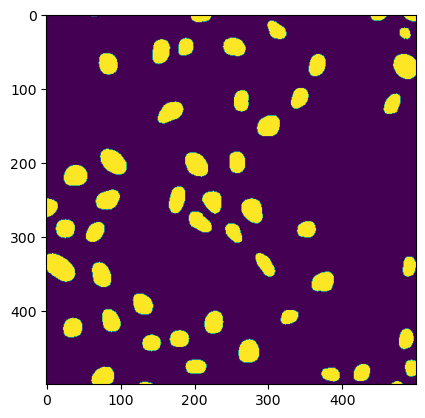

In [37]:
plt.imshow(reference_image[-1])
plt.show()

In [34]:
r_ref = np.flip(reference_image, axis = 0)

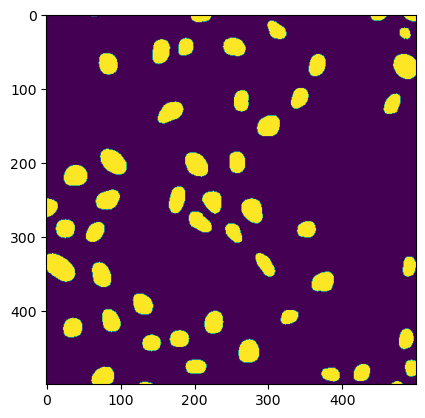

In [36]:
plt.imshow(r_ref[0])
plt.show()